In [1]:
# Packages
using Random
using DataFrames
using GLM, StatsModels
using DataTables
using DelimitedFiles, DataFrames, Lasso
using FilePaths
using StatsModels, Combinatorics
using CategoricalArrays
using StatsBase, Statistics
using TypedTables
using MacroTools
using NamedArrays
using PrettyTables 
using TexTables
using PlotlyJS
using Plots 
using StatsPlots
using Gadfly
using Random, Distributions
using Random
using PyCall
using Distributions
using KernelDensity

WebIO._IJuliaInit()

In [2]:
import Pkg

# **Multicollinearity** 

### **1. Create a matrix**
Here, we create a matrix with random values

In [3]:
Random.seed!(2) #Seed
Mat = rand(Int8,(10,9))
Mat

10×9 Matrix{Int8}:
 117   50  -118     1   26     0   -23    33    11
 -74  -28   -38    59  -29  -106    41  -123   -24
 -48   24    62   -39  -51  -123   -38  -104   127
 -53   27    90  -101  -27   -37   -37   127   126
 -45  -37    29    84  -18   -59   110   -64   -55
 102  -72    60   -84  122  -116   -81   103    -2
  30   53    33   122   35    89    -5    72  -102
 -26  -30    58    45  -30   -78   -57   -17  -108
 -78  -46   126    16   38   -66   110    58    27
  93   30  -106    92  -70   -78  -114   -32   110

### **2. Add 10th column (vector)**
The 10th column is a linear combination of other two. 

In [4]:
# Convert matrix to a dataframe to use dataframe facilities
Mat = DataFrame(Mat)

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Int8,Int8,Int8,Int8,Int8,Int8,Int8,Int8,Int8
1,117,50,-118,1,26,0,-23,33,11
2,-74,-28,-38,59,-29,-106,41,-123,-24
3,-48,24,62,-39,-51,-123,-38,-104,127
4,-53,27,90,-101,-27,-37,-37,127,126
5,-45,-37,29,84,-18,-59,110,-64,-55
6,102,-72,60,-84,122,-116,-81,103,-2
7,30,53,33,122,35,89,-5,72,-102
8,-26,-30,58,45,-30,-78,-57,-17,-108
9,-78,-46,126,16,38,-66,110,58,27


In [5]:
# 10thcol = 4thcol + 7thcol
transform!(Mat, [:x4,:x7] => (+) => :x10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
,Int8,Int8,Int8,Int8,Int8,Int8,Int8,Int8,Int8,Int8
1,117,50,-118,1,26,0,-23,33,11,-22
2,-74,-28,-38,59,-29,-106,41,-123,-24,100
3,-48,24,62,-39,-51,-123,-38,-104,127,-77
4,-53,27,90,-101,-27,-37,-37,127,126,118
5,-45,-37,29,84,-18,-59,110,-64,-55,-62
6,102,-72,60,-84,122,-116,-81,103,-2,91
7,30,53,33,122,35,89,-5,72,-102,117
8,-26,-30,58,45,-30,-78,-57,-17,-108,-12
9,-78,-46,126,16,38,-66,110,58,27,126


### **3. Invert matrix**

In [6]:
Mat = Tables.matrix(Mat)

10×10 Matrix{Int8}:
 117   50  -118     1   26     0   -23    33    11  -22
 -74  -28   -38    59  -29  -106    41  -123   -24  100
 -48   24    62   -39  -51  -123   -38  -104   127  -77
 -53   27    90  -101  -27   -37   -37   127   126  118
 -45  -37    29    84  -18   -59   110   -64   -55  -62
 102  -72    60   -84  122  -116   -81   103    -2   91
  30   53    33   122   35    89    -5    72  -102  117
 -26  -30    58    45  -30   -78   -57   -17  -108  -12
 -78  -46   126    16   38   -66   110    58    27  126
  93   30  -106    92  -70   -78  -114   -32   110  -22

In [7]:
#Inverse
Mat_inv = inv(Mat) # dataframe to array
Mat_inv = DataFrame(Mat_inv) #array to dataframe

,x1,x2,x3,x4,x5,x6,x7
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.0448348,0.020048,-0.0060669,0.060955,0.107454,0.0464987,0.0363998
2,0.0159363,-0.00174373,0.00805919,-0.00581176,-0.0141669,-0.00835517,0.000654737
3,-0.0248158,0.00752954,0.000619786,0.0285862,0.0508816,0.0222954,0.0198504
4,0.0145491,-0.00953295,0.00222457,-0.0253033,-0.0382618,-0.0168647,-0.010724
5,0.0422196,-0.0193273,0.00999094,-0.0611442,-0.0986349,-0.0374907,-0.0294179
6,-0.0135309,0.00211218,-0.0026961,0.00819554,0.015031,0.00683549,0.00670819
7,-0.0138341,0.00843776,-0.00310603,0.0251184,0.04518,0.0161554,0.0128665
8,0.0207378,-0.0112456,-0.00134779,-0.0203878,-0.038855,-0.0184672,-0.0156519
9,0.003063,-0.00434721,0.00186145,-0.00973506,-0.0155952,-0.00586016,-0.00528323


##### Julia omitted columns that were not linearly independent, so the new matrix has 10 rows and 7 columns, so this matrix cannot be inverted because it is not a square matrix. 

# Analyzing RCT data with Precision Adjustment

### **Plot histograms for treatment and control group**

In [25]:
# Load data

mat, head = readdlm("../data/penn_jae.dat", header=true, Float64)
mat
data =DataFrame(mat, vec(head))
describe(data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,abdt,10693.6,10404.0,10691.0,10880.0,0,Float64
2,tg,2.56889,0.0,2.0,6.0,0,Float64
3,inuidur1,12.9148,1.0,10.0,52.0,0,Float64
4,inuidur2,12.1938,0.0,9.0,52.0,0,Float64
5,female,0.402142,0.0,0.0,1.0,0,Float64
6,black,0.116653,0.0,0.0,1.0,0,Float64
7,hispanic,0.0363689,0.0,0.0,1.0,0,Float64
8,othrace,0.00575002,0.0,0.0,1.0,0,Float64
9,dep,0.444045,0.0,0.0,2.0,0,Float64


In [26]:
println("Number of Rows : ", size(data)[1],"\n","Number of Columns : ", size(data)[2],) #rows and columns

Number of Rows : 13913
Number of Columns : 23


Focus on the treatment group 2

In [27]:
#Subset: control and treatment dataset
penn = filter(row -> row[:tg] in [2,0], data)
first(penn, 10)

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10824.0,0.0,18.0,18.0,0.0,0.0,0.0,0.0,2.0
2,10635.0,2.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0
3,10824.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,10747.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0
5,10754.0,2.0,20.0,20.0,1.0,0.0,0.0,0.0,0.0
6,10831.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,1.0
7,10845.0,0.0,27.0,27.0,1.0,0.0,0.0,0.0,0.0
8,10831.0,0.0,9.0,9.0,1.0,0.0,0.0,0.0,1.0
9,10859.0,0.0,27.0,27.0,1.0,0.0,0.0,0.0,1.0


In [28]:
#subset for treatment and for control
treat_group = filter(row -> row[:tg] in [2], penn) #treatment
control_group = filter(row -> row[:tg] in [0], penn) #control

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10824.0,0.0,18.0,18.0,0.0,0.0,0.0,0.0,2.0
2,10824.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10747.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0
4,10831.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,1.0
5,10845.0,0.0,27.0,27.0,1.0,0.0,0.0,0.0,0.0
6,10831.0,0.0,9.0,9.0,1.0,0.0,0.0,0.0,1.0
7,10859.0,0.0,27.0,27.0,1.0,0.0,0.0,0.0,1.0
8,10516.0,0.0,15.0,15.0,1.0,0.0,0.0,0.0,0.0
9,10663.0,0.0,28.0,11.0,1.0,0.0,0.0,0.0,0.0


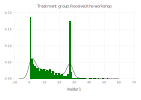

In [13]:
Gadfly.plot(treat_group, 
    layer(x = "inuidur1", Geom.density , color=[colorant"black"]),
    layer(x = "inuidur1", Geom.histogram(bincount=60, density=true, limits=(min=0,)),
    color=[colorant"green"]),
    Guide.title("Treatment group: Received the workshop")
)

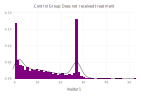

In [14]:
Gadfly.plot(control_group, Coord.cartesian(xmin=0, xmax=52),
    layer(x = "inuidur1", Geom.density , color=[colorant"black"]),
    layer(x = "inuidur1", Geom.histogram(bincount=52, density=true, limits=(min=0,)),
    color=[colorant"purple"]),
    Guide.title("Control Group: Does not received treatment")
)

### **Some data cleaning**

In [30]:
# Treatment group
replace!(penn.tg, 2 => 1) 
rename!(penn, "tg" => "T2")

# from float to string
penn[!,:dep] = string.(penn[!,:dep]) 
# dep varaible in categorical format 
penn[!,:dep] = categorical(penn[!,:dep]) 


5782-element CategoricalArray{String,1,UInt32}:
 "2.0"
 "0.0"
 "0.0"
 "0.0"
 "0.0"
 "1.0"
 "0.0"
 "1.0"
 "1.0"
 "0.0"
 "0.0"
 "0.0"
 "0.0"
 ⋮
 "0.0"
 "0.0"
 "0.0"
 "0.0"
 "0.0"
 "0.0"
 "0.0"
 "2.0"
 "0.0"
 "2.0"
 "0.0"
 "0.0"

In [31]:
describe(penn)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,abdt,10696.4,10404.0,10698.0,10880.0,0,Float64
2,T2,0.419924,0.0,0.0,1.0,0,Float64
3,inuidur1,13.0334,1.0,11.0,52.0,0,Float64
4,inuidur2,12.2511,0.0,10.0,52.0,0,Float64
5,female,0.400726,0.0,0.0,1.0,0,Float64
6,black,0.118817,0.0,0.0,1.0,0,Float64
7,hispanic,0.0363196,0.0,0.0,1.0,0,Float64
8,othrace,0.00518852,0.0,0.0,1.0,0,Float64
9,dep,,0.0,,2.0,0,"CategoricalValue{String, UInt32}"


### **Models**

In [32]:
# couples variables combinations 
combinations_upto(x, n) = Iterators.flatten(combinations(x, i) for i in 1:n)

# combinations without same couple
expand_exp(args, deg::ConstantTerm) =
    tuple(((&)(terms...) for terms in combinations_upto(args, deg.n))...)

StatsModels.apply_schema(t::FunctionTerm{typeof(^)}, sch::StatsModels.Schema, ctx::Type) =
    apply_schema.(expand_exp(t.args_parsed...), Ref(sch), ctx)

#### **1. Basic model**

In [18]:
# Basic model: linear regression

reg1 = @formula(T2 ~ (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
reg1 = apply_schema(reg1, schema(reg1, penn))
m1 = lm(reg1, penn)
table = regtable( "Covariate Balance Check" => m1)

                   | Covariate Balance Check 
                   |           (1)           
---------------------------------------------
       (Intercept) |                1.034*** 
                   |                 (0.315) 
            female |                   0.011 
                   |                 (0.260) 
             black |                  0.201* 
                   |                 (0.120) 
           othrace |                   0.346 
                   |                 (0.602) 
          dep: 1.0 |                   0.315 
                   |                 (0.373) 
          dep: 2.0 |                  -0.386 
                   |                 (0.325) 
                q2 |                  -0.218 
                   |                 (0.318) 
                q3 |                  -0.215 
                   |                 (0.318) 
                q4 |                  -0.124 
                   |                 (0.318) 
                q5 |              

#### **2. Two sample approach, no adjustment**

In [33]:
ols_cl = lm(@formula(log(inuidur1) ~ T2), penn)
table1 = regtable( "No adjustment model" => ols_cl)   

            | No adjustment model 
            |         (1)         
----------------------------------
(Intercept) |            2.057*** 
            |             (0.021) 
         T2 |            -0.079** 
            |             (0.032) 
----------------------------------
          N |                5782 
      $R^2$ |               0.001 


The ones who recieved tha treatment reduced the lenght of the first spell of unemployment in 7.9%

### **3. Classical Linear Regression Adjustment (CRA)**

In [36]:
#model
reg2 = @formula(log(inuidur1) ~ T2 + (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
reg2 = apply_schema(reg2, schema(reg2, penn))

#regression
ols_cra = lm(reg2, penn)
table2 = regtable("CRA model" => ols_cra)

                   | CRA model 
                   |    (1)    
-------------------------------
       (Intercept) |  2.447*** 
                   |   (0.381) 
                T2 |  -0.071** 
                   |   (0.032) 
            female | -0.943*** 
                   |   (0.314) 
             black | -0.508*** 
                   |   (0.146) 
           othrace |    -0.039 
                   |   (1.140) 
          dep: 1.0 |     0.280 
                   |   (0.451) 
          dep: 2.0 |     0.168 
                   |   (0.394) 
                q2 |     0.027 
                   |   (0.385) 
                q3 |    -0.354 
                   |   (0.384) 
                q4 |    -0.338 
                   |   (0.384) 
                q5 |    -0.178 
                   |   (0.383) 
                q6 |    -0.446 
                   |   (0.381) 
           agelt35 |    -0.326 
                   |   (0.326) 
           agegt54 |    -0.155 
                   |   (0.580) 
        

### **4. Intercative Regression Adjustment (IRA)**

In [37]:
# demean function, we will use this funtion later, returns a matrix
function desv_mean(a)
    A = mean(a, dims = 1)
    M = zeros(Float64, size(X,1), size(X,2))
    for i in 1:size(a,2)
          M[:,i] = a[:,i] .- A[i]
    end
    return M
end    

# Matrix Model & demean
X = StatsModels.modelmatrix(reg1.rhs,penn)
X = desv_mean(X)

5782×119 Matrix{Float64}:
 -0.400726  -0.118817  -0.00518852  -0.116569  …  -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852   0.883431  …   0.945002   -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852   0.883431     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852   0.883431     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569  …  -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0

In [39]:
Y = select(penn, [:inuidur1,:T2]) 

#interactive covariates
X = DataFrame(hcat(X, Matrix(select(penn, [:T2])).*X), :auto)  

# Joint inuidur1, T2, X y (T2*X)
base = hcat(Y, X) 
base.inuidur1 = log.(base.inuidur1)

# term.() let us to get all variables as objects
terms = term.(names(base)) 

#interactive regression model
ols_ira  = lm(terms[1] ~ sum(terms[2:end]), base)


table3 = regtable("Interactive model" => ols_ira)

            | Interactive model 
            |        (1)        
--------------------------------
(Intercept) |          2.057*** 
            |           (0.021) 
         T2 |          -0.072** 
            |           (0.032) 
         x1 |            -0.666 
            |           (0.445) 
         x2 |         -0.863*** 
            |           (0.270) 
         x3 |            -1.735 
            |           (2.173) 
         x4 |             0.036 
            |           (0.685) 
         x5 |             0.212 
            |           (0.497) 
         x6 |             0.000 
            |             (NaN) 
         x7 |          -0.367** 
            |           (0.150) 
         x8 |            -0.225 
            |           (0.154) 
         x9 |            -0.117 
            |           (0.149) 
        x10 |           -0.422* 
            |           (0.225) 
        x11 |            -0.678 
            |           (0.435) 
        x12 |            -0.304 
          

### **5. IRA ussing Lasso**

In [40]:
X = StatsModels.modelmatrix(reg2.rhs,penn) 
X = desv_mean(X)


D = DataFrame([X[:,1]], :auto) 
rename!(D, Dict(:x1 => :tg)) 

X = DataFrame(hcat(X[:,2:end], X[:,1].*X[:,2:end]), :auto)  

Y = select(penn, [:inuidur1]) 

Y.inuidur1 = log.(Y.inuidur1)  

5782-element Vector{Float64}:
 2.8903717578961645
 1.9459101490553132
 0.0
 3.295836866004329
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.1972245773362196
 3.295836866004329
 3.295836866004329
 2.70805020110221
 1.0986122886681098
 3.332204510175204
 ⋮
 2.302585092994046
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.70805020110221
 0.0
 3.1354942159291497
 1.791759469228055
 2.6390573296152584
 2.1972245773362196
 1.3862943611198906
 3.295836866004329

### **Using HDMJL**

In [59]:
#Use HDMJL
include("../hdmjl/hdmjl.jl")

In [60]:
lm(Matrix(X), vec(Matrix(D)))

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────
                Coef.     Std. Error                  t  Pr(>|t|)        Lower 95%        Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────
x1        1.70042e-12    6.07375e-12               0.28    0.7795     -1.02065e-11      1.36073e-11
x2       -7.07069e-13    4.06243e-12              -0.17    0.8618     -8.67102e-12      7.25688e-12
x3     -194.425          7.34119e-10   -264840863361.42    <1e-99   -194.425         -194.425
x4       -5.08375e-12    9.10059e-12              -0.56    0.5764     -2.29245e-11      1.27569e-11
x5       -7.02981e-12    7.84683e-12              -0.90    0.3704     -2.24127e-11      8.35304e-12
x6        0.0          NaN                       NaN       NaN       NaN      

In [64]:
#Estimation of IRA-LASSO
D_reg_0  = rlasso_arg( X, D, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

rlasso_arg(5782×238 DataFrame
  Row │ x1         x2         x3           x4         x5         x6         x7 ⋯
      │ Float64    Float64    Float64      Float64    Float64    Float64    Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329  -0.200104  -0 ⋯
    2 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
    3 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    4 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    5 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
    6 │ -0.400726  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    7 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    8 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    9 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0 ⋯
   10 │ -0

In [62]:
D_resid = rlasso(D_reg_0)

Dict{String, Any} with 19 entries:
  "tss"          => 1408.42
  "dev"          => [-0.419924, 0.580076, -0.419924, -0.419924, 0.580076, -0.41…
  "model"        => [-0.400726 -0.118817 … 0.0121229 0.0; -0.400726 -0.118817 ……
  "loadings"     => [0.24169 0.159136 … 0.0430841 0.0]
  "sigma"        => [0.493589]
  "lambda0"      => 679.639
  "lambda"       => 238×2 DataFrame…
  "intercept"    => 9.89254e-17
  "Xy"           => [-14.9637, -8.48772, -1.59772, 12.9713, -7.1093, -15.852, -…
  "iter"         => 4
  "residuals"    => [-0.419924, 0.580076, -0.419924, -0.419924, 0.580076, -0.41…
  "rss"          => 1408.42
  "index"        => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  "beta"         => 238×2 DataFrame…
  "options"      => Dict{String, Any}("intercept"=>true, "post"=>true, "meanx"=…
  "x1"           => Matrix{Float64}(undef, 5782, 0)
  "pen"          => Dict{String, Any}("lambda0"=>679.639, "lambda"=>[164.262; 1…
  "startingval"  => [-0.419924, 0.580076, -0.419

In [63]:
D_resid = rlasso(D_reg_0)["residuals"]

5782-element Vector{Float64}:
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  ⋮
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555

In [68]:
Y_reg_0  = rlasso_arg( X, Y, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )


rlasso_arg(5782×238 DataFrame
  Row │ x1         x2         x3           x4         x5         x6         x7 ⋯
      │ Float64    Float64    Float64      Float64    Float64    Float64    Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329  -0.200104  -0 ⋯
    2 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
    3 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    4 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    5 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
    6 │ -0.400726  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    7 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    8 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    9 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0 ⋯
   10 │ -0

In [69]:
Y_resid = rlasso(Y_reg_0)["residuals"]

5782-element Vector{Float64}:
  0.7317507898950092
 -0.05384734053849548
 -2.158620968001155
  1.137215898003174
  0.8371113055528355
  0.9765378557198169
  0.9765378557198169
 -0.12207443294829268
  1.137215898003174
  1.137215898003174
  0.5494292331010547
 -1.0600086793330457
  1.0129054998906915
  ⋮
  0.3028276034002372
  0.9959747839601821
  1.2960793764105205
  1.137215898003174
  0.886137646436092
 -1.9997574895938086
  1.321866894589781
 -0.36686149877310037
  0.8254300082758896
  0.19746708774241084
 -0.9330046491646216
  0.976537855719817

In [70]:
D_resid = reshape(D_resid, length(D_resid), 1)

5782×1 Matrix{Float64}:
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  ⋮
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555

In [71]:
#FINAL RESULT
Lasso_ira = lm(D_resid, Y_resid)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────
         Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────
x1  -0.0745733   0.0320861  -2.32    0.0202  -0.137474  -0.0116724
──────────────────────────────────────────────────────────────────


### **Summary Table**

In [77]:
#create an empty table
table = NamedArray(zeros(4, 5))

table[1,2] = GLM.coeftable(ols_cl).cols[1][2]
table[2,2] = GLM.coeftable(ols_cl).cols[2][2]
table[3,2] = GLM.coeftable(ols_cl).cols[5][2]
table[4,2] = GLM.coeftable(ols_cl).cols[6][2]
table[1,3] = GLM.coeftable(ols_cra).cols[1][2]
table[2,3] = GLM.coeftable(ols_cra).cols[2][2]
table[3,3] = GLM.coeftable(ols_cra).cols[5][2]
table[4,3] = GLM.coeftable(ols_cra).cols[6][2]
table[1,4] = GLM.coeftable(ols_ira).cols[1][2]
table[2,4] = GLM.coeftable(ols_ira).cols[2][2]
table[3,4] = GLM.coeftable(ols_ira).cols[5][2]
table[4,4] = GLM.coeftable(ols_ira).cols[6][2]
table[1,5] = GLM.coeftable(Lasso_ira).cols[1][1]
table[2,5] = GLM.coeftable(Lasso_ira).cols[2][1]
table[3,5] = GLM.coeftable(Lasso_ira).cols[5][1]
table[4,5] = GLM.coeftable(Lasso_ira).cols[6][1]

Tab = DataFrame(table, [ :"Statistics", :"CL", :"CRA", :"IRA", :"IRA-Lasso"])   
Tab[!,:Statistics] = string.(Tab[!,:Statistics])  

Tab[1,1] = "Estimators"
Tab[2,1] = "Standar error"
Tab[3,1] = "Lower bound CI"
Tab[4,1] = "Upper bound CI"

header = (["Statistics", "CL", "CRA", "IRA", "IRA-Lasso"])

pretty_table(Tab; backend = Val(:html), header = header, formatters=ft_round(4), alignment=:c)

LoadError: TypeError: in keyword argument backend, expected Union{Nothing, Symbol}, got a value of type Val{:html}

### **Coefficients Plot**

In [43]:
# save coeficients
#female
ira_female_coef = coef(ols_ira)[122]
ira_female_std_error = stderror(ols_ira)[122]

#black
ira_black_coef = coef(ols_ira)[123]
ira_black_std_error = stderror(ols_ira)[123]

#factor(dep)
ira_dep_coef = coef(ols_ira)[125]
ira_dep_std_error = stderror(ols_ira)[125]

#age
ira_agelt35_coef = coef(ols_ira)[131]
ira_agelt35_std_error = stderror(ols_ira)[131]

0.36128006413601615

In [44]:
# create list
coeff = [ira_female_coef,ira_black_coef,ira_dep_coef,ira_agelt35_coef]
std = [ira_female_std_error,ira_black_std_error,ira_dep_std_error,ira_agelt35_std_error]
labels = ["Treat2*Female","Treat2*Black","Treat2*agelt35","Treat2*factor(dep)1"]

4-element Vector{String}:
 "Treat2*Female"
 "Treat2*Black"
 "Treat2*agelt35"
 "Treat2*factor(dep)1"

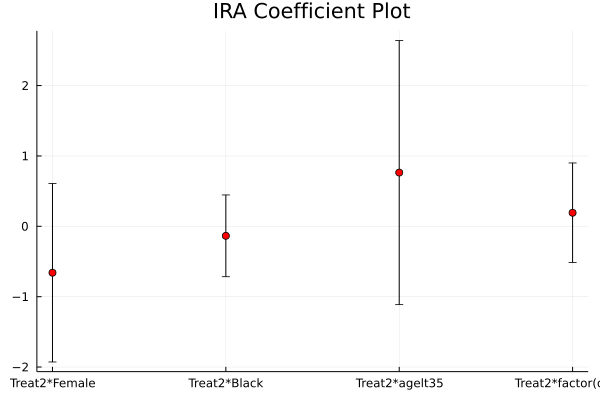

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 2:12.
└ @ Plots C:\Users\c3318\.julia\packages\Plots\dNEbX\src\utils.jl:132
┌ Info: Data contains NaNs or missing values, and indices of `seriescolor` vector do not match data indices.
│ If you intend elements of `seriescolor` to apply to individual NaN-separated segements in the data,
│ pass each segment in a separate vector instead, and use a row vector for `seriescolor`. Legend entries
│ may be suppressed by passing an empty label.
│ For example,
│     plot([1:2,1:3], [[4,5],[3,4,5]], label=["y" ""], seriescolor=[1 2])
└ @ Plots C:\Users\c3318\.julia\packages\Plots\dNEbX\src\utils.jl:134
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 2:12.
└ @ Plots C:\Users\c3318\.julia\packages\Plots\dNEbX\src\utils.jl:132
┌ Info: Data contains NaNs or missing values, and indices of `fillcolor` vector do not match data indices.
│ If you intend elements of `fillcolor` to ap

In [50]:
#coef plot
Plots.scatter(labels, coeff, legend = false, yerror = 1.96 .* std, title = "IRA Coefficient Plot", color = [colorant"red"])

## **Kaggle Replications**

One of the earliest randomized experiments were the Polio vaccination trias conducted by the Public Health Service in 1954. The question was whether Salk vaccine prevented polio. Children in the study were randomly assigned either a treatment (polio vaccine shot) or a placebo (saline solution shot), without knowing which one they received. The doctors in the study, making the diagnosis, did not know whether a child received a vaccine or not. In other words, the trial was a double-blind, randomized control trial. The trial had to be large, because the rate at which Polio occured in the population was 50 per 100,000. The treatment group saw 33 polio cases per 200,745; the control group saw 115 cases per 201,229. The estimated avearage treatment effect is about $$ -40 $$ with the 95% confidence band (based on approximate normality of the two sample means and their differences): $$ [-52, -28]. $$ As this is an RCT, the confidence band suggests that the Polio vaccine caused the reduction in the risk of polio.

The interesting thing here is that we don't need the underlying individual data to evaluate the effectivess of the vaccine. This is because the outcomes are Bernoulli random variables, and we have enough information to compute the estimate of ATE as well as the confidence intervals from the group case counts.

We also compute the Vaccine Efficacy metric, which refers to the following measure according to the CDC: $$ VE = \frac{Risk for Unvaccinated - Risk for Vaccinated}{Risk for Unvaccinated} $$ It describes the relative reduction in risk caused by vaccination.

It is staighforward to get the VE estimate by just plugging-in the numbers, but how do we get the approximate variance estimate? I am too lazy to do calculations for the delta method, so I will just use a simulation (a form of approximate bootstrap) to obtain the confidence intervals.

In [78]:
NT = 200745 #number of treated

NC = 201229 #number of controlled

YT = 33/NT  #average outcome for treated

YC =115/NC  #average outcome for controlled

0.0005714882049803955

In [79]:
#incidence per 100000 

println("Incidence per 100000 among treated: " ,YT*100000)
println( "Incidence per 100000 among controlled: ", YC*100000)

Incidence per 100000 among treated: 16.438765598146905
Incidence per 100000 among controlled: 57.14882049803955


In [81]:

delta_hat = 100000*(YT-YC)
Var_delta_hat =  (100000^2)*(YT*(1-YT)/NT +  YC*(1-YC)/NC)

36.57119577658993

In [83]:
# treatment effect estimate reduction in incidence  per 100000 people
println("Estimate TE of occurances per 100,000 " ,delta_hat)
println("Standard deviation for ATE: ",  Var_delta_hat^.5)

Estimate TE of occurances per 100,000 -40.71005489989265
Standard deviation for ATE: 6.047412320702958


In [90]:
# here we are using the fact that outcomes are Bernoulli 

CI_low = delta_hat -1.96*Var_delta_hat^.5
CI_up = delta_hat +1.96*Var_delta_hat^.5
CI_delta = [CI_low, CI_up]


println("95 % confidence interval is [ " , CI_low , ",", CI_up , "]")

95 % confidence interval is [ -52.56298304847044,-28.85712675131485]


In [91]:
# Here we calculate the overall effectiveness of the vaccine and construct confidence intervals for it

NV =  200745
NU =  201229
RV = 33/NV
RU = 115/NU
VE = (RU - RV)/RU
println("Overall VE is ", VE)

Overall VE is 0.7123516206478694


In [92]:
# this recovers the number in the table.

# we set up a simulation example.

# calulate variance of risk estimates:

Var_RV = RV*(1-RV)/NV
Var_RU = RU*(1-RU)/NU

2.8383662703286493e-9